<a href="https://colab.research.google.com/github/dr-zool/tcu-ai/blob/main/lab-module/pytorch_of_train_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount gdrive to colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Packages**

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import cv2

**Define data directory in google drive**

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/data_dogcat/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/data_dogcat/validation"

In [ ]:
!ls train_dir

ls: cannot access 'train_dir': No such file or directory


**Set Batch Size, Train and Validation Data Loader**

In [ ]:
# Define the batch size
batch_size = 32

# Define the data transformations
train_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=0, shear=10),  # shear_range
    transforms.RandomHorizontalFlip(),  # horizontal_flip
    transforms.Resize((224, 224)),  # target_size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Simplified normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # target_size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Simplified normalization
])

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

**Transfer Learning using Resnet50 - Freeze all the concolution layer except Header**

**Set the Header**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomResNet50(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResNet50, self).__init__()
        # Load pre-trained ResNet50 model without the top (fully connected) layer
        self.conv_base = models.resnet50(pretrained=True)
        for param in self.conv_base.parameters():
            param.requires_grad = False

        # Add global average pooling
        self.conv_base.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Replace the fully connected layer
        num_ftrs = self.conv_base.fc.in_features
        self.conv_base.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        if len(x.shape) == 5:  # If the input has shape [batch_size, 32, 3, 224, 224]
            x = x.view(-1, x.shape[2], x.shape[3], x.shape[4])  # Flatten the batch and sequence dimensions
        x = self.conv_base(x)
        return x

# Instantiate the model
model = CustomResNet50()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 41.7MB/s]


**Compile and Train the Header**

In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet50(
  (conv_base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
# Define the optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define accuracy metric
def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    accuracy = correct / target.size(0)
    return accuracy


In [ ]:
from tqdm import tqdm # for training progress bar

# Lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Initialize variables to track the lowest test loss and corresponding model
lowest_test_loss = float('inf')
best_model = None

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training with progress bar
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False)

    for images, labels in train_progress:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        #print(images.shape)

        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_accuracy = 100 * (correct / float(total))

    # Save training loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'\nEpoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Evaluate the model on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        test_progress = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Testing", leave=False)
        for images, labels in test_progress:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= total
    test_accuracy = 100 * (correct / float(total))

    # Save test loss and accuracy
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check if the current test loss is the lowest encountered so far
    if test_loss < lowest_test_loss:
        lowest_test_loss = test_loss
        # Save the model state
        best_model = model

print('Training complete')



Epoch [1/10], Train Loss: 5.1502, Train Accuracy: 50.83%


Epoch [1/10], Test Loss: 1.2809, Test Accuracy: 48.48%



Epoch [2/10], Train Loss: 0.9626, Train Accuracy: 58.33%


Epoch [2/10], Test Loss: 0.2813, Test Accuracy: 92.93%



Epoch [3/10], Train Loss: 0.5490, Train Accuracy: 66.67%


Epoch [3/10], Test Loss: 0.1857, Test Accuracy: 97.98%



Epoch [4/10], Train Loss: 0.1931, Train Accuracy: 95.83%


Epoch [4/10], Test Loss: 0.1164, Test Accuracy: 100.00%



Epoch [5/10], Train Loss: 0.1497, Train Accuracy: 95.83%


Epoch [5/10], Test Loss: 0.1147, Test Accuracy: 100.00%



Epoch [6/10], Train Loss: 0.1570, Train Accuracy: 95.00%


Epoch [6/10], Test Loss: 0.5364, Test Accuracy: 70.71%



Epoch [7/10], Train Loss: 0.1705, Train Accuracy: 92.50%


Epoch [7/10], Test Loss: 0.1185, Test Accuracy: 94.95%



Epoch [8/10], Train Loss: 0.4266, Train Accuracy: 80.00%


Epoch [8/10], Test Loss: 0.3527, Test Accuracy: 80.81%



Epoch [9/10], Train Loss: 0.2449, Train Accuracy: 90.83%


Epoch [9/10], Test Loss: 0.0995, Test Accuracy: 98.99%



Epoch [10/10], Train Loss: 0.0956, Train Accuracy: 99.17%


Epoch [10/10], Test Loss: 0.1017, Test Accuracy: 95.96%
Training complete


**Save and Load Model**

In [ ]:
#model.save('')

from google.colab import drive
drive.mount('/content/drive')

# Save the best model to a file
torch.save(best_model, '/content/drive/My Drive/Colab Notebooks/best_model_catdog_resnet50.pth')
print("Saved entire model to disk with pth format")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved entire model to disk with pth format


In [ ]:
model=torch.load('/content/drive/My Drive/Colab Notebooks/best_model_catdog_resnet50.pth')
model.eval()  # Set the model to evaluation mode


<ipython-input-16-678ae7f014dc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('/content/drive/My Drive/Colab Notebooks/best_model_catdog_resnet50.pth')


CustomResNet50(
  (conv_base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

**Get the tested images**

In [ ]:
validation_img_paths = ["/content/drive/My Drive/Colab Notebooks/dataset/data_dogcat/validation/dogs/dog.1002.jpg",
                        "/content/drive/My Drive/Colab Notebooks/dataset/data_dogcat/validation/dogs/dog.1001.jpg",
                        "//content/drive/My Drive/Colab Notebooks/dataset/data_dogcat/validation/cats/cat.1000.jpg"]

# Load and transform images
img_list = [val_transforms(Image.open(img_path).convert("RGB")) for img_path in validation_img_paths]

# Check if images are transformed correctly
for img in img_list:
    print(type(img))  # Should print <class 'torch.Tensor'>

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
# Define a function to get the predicted class
def get_prediction_class(prediction_tensor):
    if prediction_tensor[0][1] > prediction_tensor[0][0]:
        return "dog"
    else:
        return "cat"

**Make Prediction and Display The Results on the tested Dataset**

In [ ]:
# Evaluate the model on each image
model.eval()
for image_path in validation_img_paths:
    img = Image.open(image_path).convert("RGB")
    img_tensor = val_transforms(img).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(img_tensor)

    # Convert the output tensor into human-readable class label
    predicted_class = get_prediction_class(output)

    # Print the prediction result
    print(f"Image: {image_path}, Predicted class: {predicted_class}")

Image: /content/drive/My Drive/Colab Notebooks/dataset/data_dogcat/validation/dogs/dog.1002.jpg, Predicted class: dog
Image: /content/drive/My Drive/Colab Notebooks/dataset/data_dogcat/validation/dogs/dog.1001.jpg, Predicted class: dog
Image: //content/drive/My Drive/Colab Notebooks/dataset/data_dogcat/validation/cats/cat.1000.jpg, Predicted class: cat


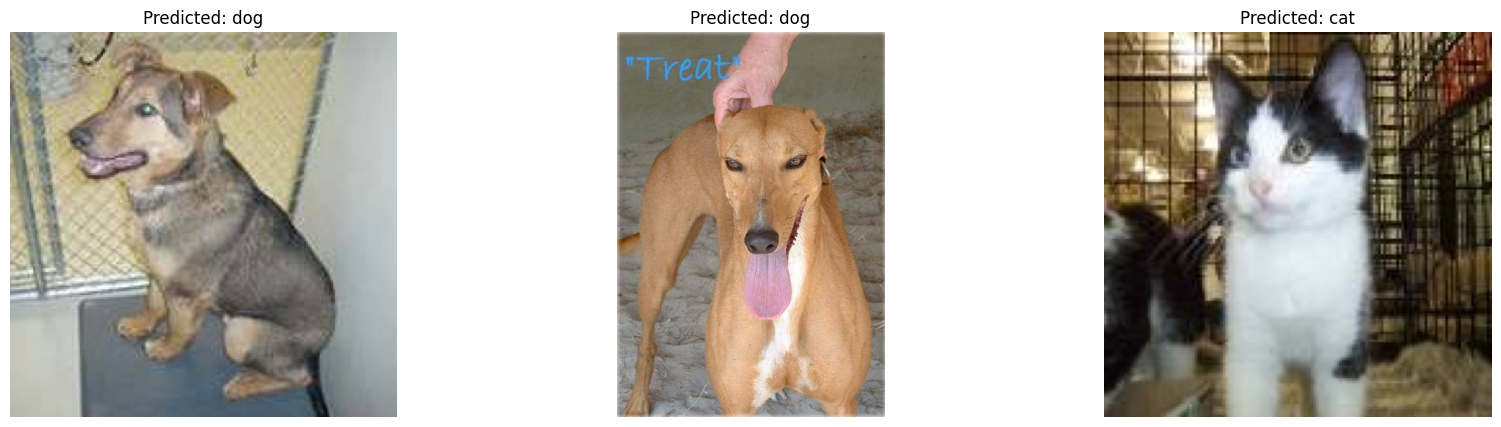

In [ ]:
import matplotlib.pyplot as plt

# Define the figure and axes
fig, axs = plt.subplots(1, len(validation_img_paths), figsize=(20, 5))

# Iterate over each image, make predictions, and plot
for i, image_path in enumerate(validation_img_paths):
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = val_transforms(img).unsqueeze(0)  # Add batch dimension

    # Evaluate the model on the image
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)

    # Convert the output tensor into human-readable class label
    predicted_class = get_prediction_class(output)

    # Plot the image
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Predicted: {predicted_class}")

# Show the plot
plt.show()
